In [200]:
import os
import math
from pathlib import Path

import numpy  as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

# models
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import r2_score, f1_score, accuracy_score

In [2]:
path_to_csv = Path(os.getcwd()).parent / 'data' / 'processed_data' / 'dataset_2_shape_experiment_1.csv'

df = pd.read_csv(path_to_csv)

## Basic Analysis of the Dataframe

In [3]:
df.shape

(14948, 26)

In [4]:
df.columns

Index(['date_str', 'distance_setting', 'is_retina_display', 'is_lab',
       'is_practice', 'duration_ms', 'number_of_objects', 'number_of_trials',
       'participant', 'TrialNumber', 'target_present', 'ran', 'order',
       'trial_id', 'response_yes', 'yes_no_correct', 'rt_sec', 'rt_where_sec',
       'response_where_x', 'response_where_y', 'target_pos_x', 'target_pos_y',
       'click_distance_deg', 'distance_shapecomp', 'background_shape_idx',
       'proto_object_idx'],
      dtype='object')

In [25]:
df.head()

,participant,distance_setting,number_of_objects,target_present,response_yes,yes_no_correct,target_pos_x,response_where_x,target_pos_y,response_where_y,hit,false_alarm
20,SR,low,3,False,0.0,1.0,NaN,NaN,NaN,NaN,0,0
21,SR,low,3,True,1.0,1.0,-5.434043,-2.645458,-1.889708,-6.242093,1,0
22,SR,low,3,True,0.0,0.0,9.235096,NaN,6.121561,NaN,0,0
23,SR,low,3,True,1.0,1.0,-10.409420,6.256955,-6.866167,-7.921513,1,0
24,SR,low,3,False,0.0,1.0,NaN,NaN,NaN,NaN,0,0


## Basic Data Exploration and Processing

In [6]:
# are there any practice trials?
print(f'The DataFrame contains {len(df[df.is_practice == True])} practice and {len(df[df.is_practice == False])} experiment trials.')

# the fact that there are only 148 = 14800 / 100 practice trials is strange, should be at least ~10 times more

# in the following code, only non-practice trials are considered
df = df[df.is_practice == False]

print(f'After removing practice data, the DataFrame contains {len(df)} rows.')

The DataFrame contains 148 practice and 14800 experiment trials.
After removing practice data, the DataFrame contains 14800 rows.


In [7]:
df.participant.unique()

array(['sr', 'JT', 'HT', 'DH', 'OF', 'RS', 'DB', 'MG', 'JH', 'NS'],
      dtype=object)

In [8]:
df.distance_setting.unique()

array(['low', 'mid', 'high'], dtype=object)

In [9]:
df.number_of_objects.unique()

array([ 3,  4, 16,  2,  8], dtype=int64)

In [10]:
df.is_retina_display.unique()

array([False])

In [11]:
df.is_lab.unique()

array([ True])

In [12]:
df.duration_ms.unique()

array([300], dtype=int64)

In [13]:
df.number_of_trials.unique()

array([50], dtype=int64)

In [14]:
df.columns

Index(['date_str', 'distance_setting', 'is_retina_display', 'is_lab',
       'is_practice', 'duration_ms', 'number_of_objects', 'number_of_trials',
       'participant', 'TrialNumber', 'target_present', 'ran', 'order',
       'trial_id', 'response_yes', 'yes_no_correct', 'rt_sec', 'rt_where_sec',
       'response_where_x', 'response_where_y', 'target_pos_x', 'target_pos_y',
       'click_distance_deg', 'distance_shapecomp', 'background_shape_idx',
       'proto_object_idx'],
      dtype='object')

In [15]:
#####################
# Rearrange Columns #
#####################

# parameter columns
filter_cols = ['participant', 'distance_setting', 'number_of_objects', 'target_present']

# trial information
binary_task_cols = ['response_yes', 'yes_no_correct']

# position data
position_task_cols = ['target_pos_x', 'response_where_x', 'target_pos_y', 'response_where_y']

# misc data, mostly constant or relating to meta information
constants  = ['is_retina_display', 'is_lab', 'is_practice', 'duration_ms', 'number_of_trials']
meta = ['TrialNumber', 'date_str', 'trial_id']

# change participant 'sr' to uppercase in order to conform with other values
df.loc[(df['participant'] == 'sr'), 'participant'] = 'SR'

# rearrange columns
df = df[filter_cols + binary_task_cols + position_task_cols]

In [16]:
df.columns

Index(['participant', 'distance_setting', 'number_of_objects',
       'target_present', 'response_yes', 'yes_no_correct', 'target_pos_x',
       'response_where_x', 'target_pos_y', 'response_where_y'],
      dtype='object')

In [20]:
df.loc[(df['participant'] == 'DH'), filter_cols + binary_task_cols]

,participant,distance_setting,number_of_objects,target_present,response_yes,yes_no_correct
440,DH,high,16,False,0.0,1.0
441,DH,high,16,False,0.0,1.0
442,DH,high,16,False,0.0,1.0
443,DH,high,16,True,0.0,0.0
444,DH,high,16,False,1.0,0.0
...,...,...,...,...,...,...
14843,DH,high,2,False,0.0,1.0
14844,DH,high,2,True,1.0,1.0
14845,DH,high,2,True,1.0,1.0
14846,DH,high,2,True,1.0,1.0


### Add Hits and FAs

In [27]:
# add hits
df['hit'] = 0
df.loc[(df['target_present'] == True) & (df['response_yes'] == 1.), 'hit'] = 1

df['false_alarm'] = 0
df.loc[(df['target_present'] == False) & (df['response_yes'] == 1.), 'false_alarm'] = 1

hit_fa_cols = ['hit', 'false_alarm']

In [28]:
df.loc[(df['participant'] == 'DH'), filter_cols + hit_fa_cols + position_task_cols]

,participant,distance_setting,number_of_objects,target_present,hit,false_alarm,target_pos_x,response_where_x,target_pos_y,response_where_y
440,DH,high,16,False,0,0,NaN,NaN,NaN,NaN
441,DH,high,16,False,0,0,NaN,NaN,NaN,NaN
442,DH,high,16,False,0,0,NaN,NaN,NaN,NaN
443,DH,high,16,True,0,0,5.635641,NaN,-2.871181,NaN
444,DH,high,16,False,0,1,NaN,1.382178,NaN,7.371614
...,...,...,...,...,...,...,...,...,...,...
14843,DH,high,2,False,0,0,NaN,NaN,NaN,NaN
14844,DH,high,2,True,1,0,-5.978004,-6.197506,-8.535191,-7.579684
14845,DH,high,2,True,1,0,10.579577,9.853589,-0.884105,2.883252
14846,DH,high,2,True,1,0,5.053192,8.634895,-1.975714,-1.025487


In [95]:
# recover positional parameters used in the generation of targets
df['distance'] = np.sqrt(df['target_pos_x'] ** 2 + df['target_pos_y'] ** 2)
df['angle'] = np.arctan2(df['target_pos_y'], df['target_pos_x'])
positional_info_cols = ['distance', 'angle']

In [96]:
df.loc[(df['participant'] == 'DH'), filter_cols + binary_task_cols + hit_fa_cols + positional_info_cols + position_task_cols].head()

,participant,distance_setting,number_of_objects,target_present,response_yes,yes_no_correct,hit,false_alarm,distance,angle,target_pos_x,response_where_x,target_pos_y,response_where_y
400,DH,high,16,False,0.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
401,DH,high,16,False,0.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
402,DH,high,16,False,0.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
403,DH,high,16,True,0.0,0.0,0,0,6.324882,-0.471194,5.635641,NaN,-2.871181,NaN
404,DH,high,16,False,1.0,0.0,0,1,NaN,NaN,NaN,1.382178,NaN,7.371614


In [97]:
df['distance_delta'] = np.sqrt((df['target_pos_x'] - df['response_where_x']) ** 2 + (df['target_pos_y'] - df['response_where_y']) ** 2)

In [98]:
df.loc[(df['participant'] == 'DH'), filter_cols + binary_task_cols + hit_fa_cols + positional_info_cols + position_task_cols + ['distance_delta']]

,participant,distance_setting,number_of_objects,target_present,response_yes,yes_no_correct,hit,false_alarm,distance,angle,target_pos_x,response_where_x,target_pos_y,response_where_y,distance_delta
400,DH,high,16,False,0.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,DH,high,16,False,0.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,DH,high,16,False,0.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,DH,high,16,True,0.0,0.0,0,0,6.324882,-0.471194,5.635641,NaN,-2.871181,NaN,NaN
404,DH,high,16,False,1.0,0.0,0,1,NaN,NaN,NaN,1.382178,NaN,7.371614,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14695,DH,high,2,False,0.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14696,DH,high,2,True,1.0,1.0,1,0,10.420461,-2.181787,-5.978004,-6.197506,-8.535191,-7.579684,0.980395
14697,DH,high,2,True,1.0,1.0,1,0,10.616454,-0.083373,10.579577,9.853589,-0.884105,2.883252,3.836671
14698,DH,high,2,True,1.0,1.0,1,0,5.425698,-0.372709,5.053192,8.634895,-1.975714,-1.025487,3.705608


In [132]:
df = df.loc[df['yes_no_correct'].notna(), :]

In [219]:
save_path = path_to_csv = Path(os.getcwd()).parent / 'data' / 'processed_data' / 'exp_1_processed.csv'
df.to_csv(save_path)

### Plot Relationships between Hits/FAs and Target Pos

In [133]:
def plot_annulus(
    df : pd.DataFrame,
    participant : str,
) -> None:
    nrows = len(df['number_of_objects'].unique())
    ncols = len(df['distance_setting'].unique())
    fig, ax = plt.subplots(figsize=(3 * ncols, 3 * nrows), nrows=nrows, ncols=ncols)
    
    for i, n in enumerate(df['number_of_objects'].unique()):
        for j, d in enumerate(df['distance_setting'].unique()):
            
            sns.scatterplot(
                data=df.loc[(df['number_of_objects'] == n) & (df['distance_setting'] == d), :],
                x='target_pos_x',
                y='target_pos_y',
                hue='yes_no_correct',
                ax=ax[i, j],
            )
            
    plt.show()

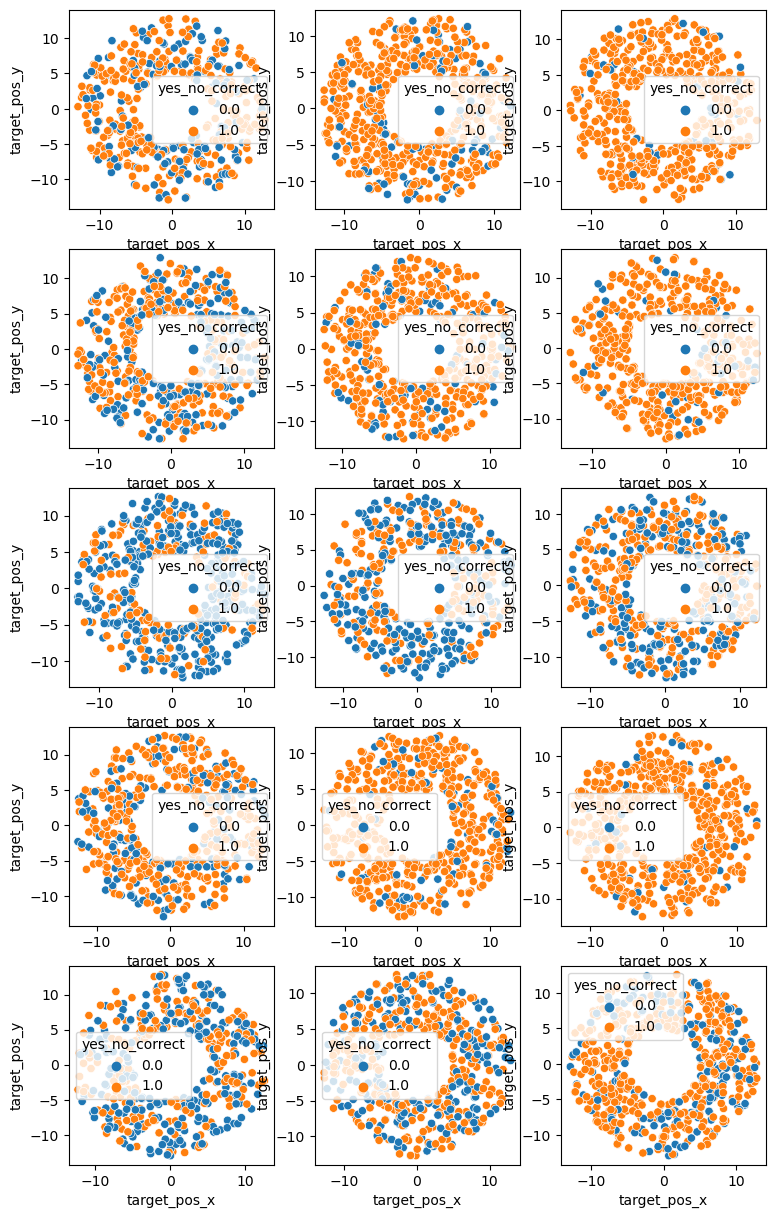

In [134]:
plot_annulus(df, 'DH')

### Train Logistic Regression on Position Data

Hypothesis: neither the distance nor the angle alone provide much predictive power

min: 5.000521771215782, max: 12.998080661920982


<Axes: >

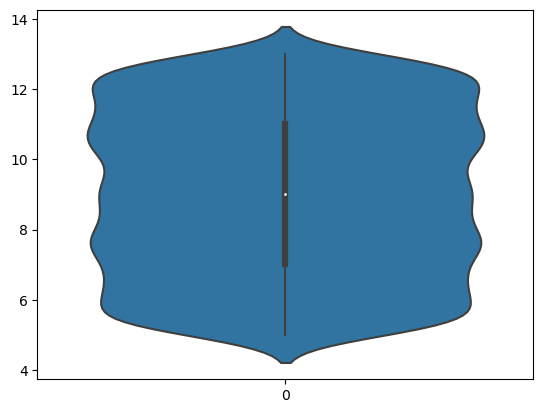

In [135]:
# sample data for logistic regression
print(f'min: {df.distance.min()}, max: {df.distance.max()}')
sns.violinplot(df.distance)

The data appears to have been drawn from the uniform distribution in the range from 5 to 13. 

Sample data in the same range, and introduce a linear relationship between distance and the ability of the participant to correctly identify the target.

<Axes: >

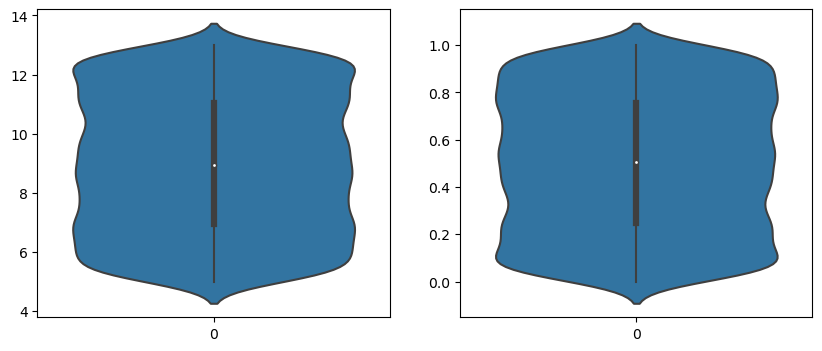

In [136]:
# sample distances using the same process
X_sample = stats.uniform.rvs(5, 8, size=10000)

# introduce a relationship between the distance and the response via probability dependet on distance
p_sample = 1 - (X_sample - 5) / 8

# sample responses using manipulated probabilities
y_sample = np.array([stats.bernoulli.rvs(p) for p in p_sample])

fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
sns.violinplot(X_sample, ax=ax[0])
sns.violinplot(p_sample, ax=ax[1])

In [212]:
np.unique(y_sample, return_counts=True)

(array([0, 1]), array([4933, 5067], dtype=int64))

In [213]:
# train logistic regression using generated data
features = X_sample.reshape(-1, 1)

logreg = LogisticRegression().fit(
    X=features,
    y=y_sample,
)

print(f'logistic regression function with intercept {logreg.intercept_} and coefficients {logreg.coef_}')

# predict the data that the model was trained on and calculate r^2 of these predictions
r_squared = r2_score(
    y_true=y_sample,
    y_pred=logreg.predict(X=features),
)

# predict the data that the model was trained on and calculate F1 of these predictions
accuracy = accuracy_score(
    y_true=y_sample,
    y_pred=logreg.predict(X=features),
)

print(f'logistic regression conditioned on distance achieves an r^2 of {r_squared} and an accuracy of {accuracy}')

logistic regression function with intercept [5.82660185] and coefficients [[-0.64415213]]
logistic regression conditioned on distance and angle achieves an r^2 of -0.003380166942776208 and an accuracy of 0.7492


In [202]:
df.yes_no_correct.value_counts()

1.0    11316
0.0     3476
Name: yes_no_correct, dtype: int64

In [208]:
# a naive model can achieve
print(f'A completely naive majority-vote model can achieve an accuracy of {df.yes_no_correct.value_counts()[1.0] / len(df.yes_no_correct)}')

A completely naive majority-vote model can achieve an accuracy of 0.7650081124932396


In [201]:
# train logistic regression using only distance data
features = df.loc[df['distance'].notna(), 'distance'].values.reshape(-1, 1)

logreg = LogisticRegression().fit(
    X=features,
    y=df.loc[df['distance'].notna(), 'yes_no_correct'],
)

print(f'logistic regression function with intercept {logreg.intercept_} and coefficients {logreg.coef_}')

# predict the data that the model was trained on and calculate r^2 of these predictions
r_squared = r2_score(
    y_true=df.loc[df['distance'].notna(), 'yes_no_correct'],
    y_pred=logreg.predict(X=features),
)

# predict the data that the model was trained on and calculate F1 of these predictions
accuracy = accuracy_score(
    y_true=df.loc[df['distance'].notna(), 'yes_no_correct'],
    y_pred=logreg.predict(X=features),
)

print(f'logistic regression conditioned on distance achieves an r^2 of {r_squared} and an accuracy of {accuracy}')

logistic regression function with intercept [1.00720597] and coefficients [[-0.02590274]]
logistic regression conditioned on distance and angle achieves an r^2 of -0.4615688599091088 and an accuracy of 0.6841962957955928


In [203]:
# train logistic regression using distance and angle data
features = df.loc[df['distance'].notna(), ['distance', 'angle']].values

logreg = LogisticRegression().fit(
    X=features,
    y=df.loc[df['distance'].notna(), 'yes_no_correct'],
)

print(f'logistic regression function with intercept {logreg.intercept_} and coefficients {logreg.coef_}')

# predict the data that the model was trained on and calculate r^2 of these predictions
r_squared = r2_score(
    y_true=df.loc[df['distance'].notna(), 'yes_no_correct'],
    y_pred=logreg.predict(X=features),
)

# predict the data that the model was trained on and calculate F1 of these predictions
accuracy = accuracy_score(
    y_true=df.loc[df['distance'].notna(), 'yes_no_correct'],
    y_pred=logreg.predict(X=features),
)

print(f'logistic regression conditioned on distance and angle achieves an r^2 of {r_squared} and an accuracy of {accuracy}')

logistic regression function with intercept [1.00755677] and coefficients [[-0.02570894  0.04045607]]
logistic regression conditioned on distance and angle achieves an r^2 of -0.4615688599091088 and an accuracy of 0.6841962957955928


### Add Number of Objects into the Mix

In [204]:
one_hot_number_of_objects = OneHotEncoder().fit_transform(df.loc[df['distance'].notna(), ['number_of_objects']]).toarray()

In [214]:
# train logistic regression using distance and angle as well as shapecomp distance data
features = df.loc[df['distance'].notna(), ['distance', 'angle']].values
features = np.column_stack((features, one_hot_number_of_objects))

logreg = LogisticRegression().fit(
    X=features,
    y=df.loc[df['distance'].notna(), 'yes_no_correct'],
)

print(f'logistic regression function with intercept {logreg.intercept_} and coefficients {logreg.coef_}')

# predict the data that the model was trained on and calculate r^2 of these predictions
r_squared = r2_score(
    y_true=df.loc[df['distance'].notna(), 'yes_no_correct'],
    y_pred=logreg.predict(X=features),
)

# predict the data that the model was trained on and calculate F1 of these predictions
accuracy = accuracy_score(
    y_true=df.loc[df['distance'].notna(), 'yes_no_correct'],
    y_pred=logreg.predict(X=features),
)

print(f'logistic regression conditioned on distance and angle as well as the number of objects achieves an r^2 of {r_squared} and an accuracy of {accuracy}')

logistic regression function with intercept [1.11038204] and coefficients [[-0.02898136  0.04238571  0.69335907  0.64107142  0.26464426 -0.48010354
  -1.11555514]]
logistic regression conditioned on distance and angle as well as the number of objects achieves an r^2 of -0.3401885693173421 and an accuracy of 0.7104231445180479


### And now with distance setting

In [209]:
one_hot_distance_setting = OneHotEncoder().fit_transform(df.loc[df['distance'].notna(), ['distance_setting']]).toarray()

In [215]:
# train logistic regression using distance and angle as well as shapecomp distance data
features = df.loc[df['distance'].notna(), ['distance', 'angle']].values
features = np.column_stack((features, one_hot_number_of_objects, one_hot_distance_setting))

logreg = LogisticRegression().fit(
    X=features,
    y=df.loc[df['distance'].notna(), 'yes_no_correct'],
)

print(f'logistic regression function with intercept {logreg.intercept_} and coefficients {logreg.coef_}')

# predict the data that the model was trained on and calculate r^2 of these predictions
r_squared = r2_score(
    y_true=df.loc[df['distance'].notna(), 'yes_no_correct'],
    y_pred=logreg.predict(X=features),
)

# predict the data that the model was trained on and calculate F1 of these predictions
accuracy = accuracy_score(
    y_true=df.loc[df['distance'].notna(), 'yes_no_correct'],
    y_pred=logreg.predict(X=features),
)

print(f'logistic regression conditioned on distance and angle as well as the number of objects and the distance setting achieves an r^2 of {r_squared} and an accuracy of {accuracy}')

logistic regression function with intercept [1.20089579] and coefficients [[-0.03322975  0.04428075  0.7534175   0.66664413  0.32272679 -0.5522563
  -1.19116968  0.70401481 -0.74527621  0.04062383]]
logistic regression conditioned on distance and angle as well as the number of objects and the distance setting achieves an r^2 of -0.27887275242047016 and an accuracy of 0.7236717588211438


### Using only the number of objects and the distance setting

In [216]:
# train logistic regression using distance and angle as well as shapecomp distance data
features = np.column_stack((one_hot_number_of_objects, one_hot_distance_setting))

logreg = LogisticRegression().fit(
    X=features,
    y=df.loc[df['distance'].notna(), 'yes_no_correct'],
)

print(f'logistic regression function with intercept {logreg.intercept_} and coefficients {logreg.coef_}')

# predict the data that the model was trained on and calculate r^2 of these predictions
r_squared = r2_score(
    y_true=df.loc[df['distance'].notna(), 'yes_no_correct'],
    y_pred=logreg.predict(X=features),
)

# predict the data that the model was trained on and calculate F1 of these predictions
accuracy = accuracy_score(
    y_true=df.loc[df['distance'].notna(), 'yes_no_correct'],
    y_pred=logreg.predict(X=features),
)

print(f'logistic regression conditioned on the number of objects and the distance setting achieves an r^2 of {r_squared} and an accuracy of {accuracy}')

logistic regression function with intercept [0.89738732] and coefficients [[ 0.75226466  0.66573457  0.32252564 -0.55318345 -1.18730502  0.70219394
  -0.74225629  0.04009875]]
logistic regression conditioned on the number of objects and the distance setting achieves an r^2 of -0.27887275242047016 and an accuracy of 0.7236717588211438
